In [3]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
import json
import math
import multiprocessing
import os
from pathlib import Path
import random

# Import utility functions
from cjm_pil_utils.core import resize_img, stack_imgs
from cjm_pytorch_utils.core import tensor_to_pil, get_torch_device, set_seed, move_data_to_device
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import cv2
from torchvision.transforms import ToTensor

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

In [4]:
# device = get_torch_device()
device = 'cpu'
dtype = torch.float32

# Prepend a `background` class to the list of class names
class_names = ['background']+['crater']

# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

In [5]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2)

In [6]:
# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /home/james/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:24<00:00, 7.67MB/s] 


In [8]:
image_dir = 'data/sofia_data_v2/ground_truth_images'
images_ellipses_dir = 'data/sofia_data_v2/ground_truth_projected_ellipses'

image_dir_items = [i.split(".")[0] for i in os.listdir(image_dir)]
images_ellipses_dir_items = [i.split(".")[0] for i in os.listdir(images_ellipses_dir)]
items = list(set(image_dir_items) & set(images_ellipses_dir_items))
items = sorted(items, key=lambda x: int(x.split('.')[0]))

images_name = [i+'.png' for i in items]
ellipses_name = [i+'.txt' for i in items]

img_dict = {i: os.path.join(image_dir, f'{item}.png') for i, item in enumerate(items)}

# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

In [9]:
class CratersDataset(Dataset):
    def __init__(self, img_keys, anno_ellipses_dir, img_dict, class_to_idx, transforms=None):
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys  # List of image keys
        self._anno_ellipses_dir = anno_ellipses_dir
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied
        
    def __len__(self):
        return len(self._img_keys)
        
    def __getitem__(self, index):
        # Retrieve the key for the image at the specified index
        img_path = self._img_dict[index]
        # # Get the annotations for this image
        annot_filename = img_path.split('/')[-1].split('.')[0] + '.txt'
        annot_file_path = os.path.join(self._anno_ellipses_dir, annot_filename)

        # Load the image and its target (segmentation masks, bounding boxes and labels)
        image, target = self._load_image_and_target(img_path, annot_file_path)        
        
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target
    
    @staticmethod
    def __get_mask( x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation) -> np.ndarray:
        mask = np.zeros((1024, 1024), dtype=np.uint8)
     
        cv2.ellipse(mask, (int(x_centre), int(y_centre)),
                    (int(semi_major_axis), int(semi_minor_axis)),
                    angle=rotation, startAngle=0, endAngle=360,
                    color=1, thickness=-1)
        mask = Image.fromarray(mask, mode='L')
        return mask
    
    @staticmethod
    def __get_box(mask: np.ndarray):
        pos = np.nonzero(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def _load_image_and_target(self, img_path, annot_file_path):
        image = Image.open(img_path).convert('RGB')
        image_tensor = ToTensor()(image)
        
        target = {
            "boxes": [],
            "masks": [],
            "labels": [],
        }
        with open(annot_file_path, "r") as f:
            lines = f.readlines()[1:]
            for line in lines:
                label = 1 
                data = line.strip().split(',')
                # Extract ellipse parameters
                x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation = map(float, data)
                rotation = np.degrees(rotation)
                mask = self.__get_mask(x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation)
                
                box = self.__get_box(mask)
                target["masks"].append(mask)    
                target["boxes"].append(box)
                target["labels"].append(label)


        
        # Convert the class labels to indices
        labels_tensor = torch.Tensor(target['labels']).to(dtype=torch.int64)

        # masks_tensor = torch.stack([torch.Tensor(mask) for mask in target['masks']])

        # Generate bounding box annotations from segmentation masks
        # bboxes_tensor = torch.Tensor(target['boxes']).to(dtype=torch.float32)
        
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in target["masks"]]))

        # Generate bounding box annotations from segmentation masks
        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=image.size[::-1])

        
                
        return image, {'masks': masks,'boxes': bboxes, 'labels': labels_tensor}

In [10]:
train_sz = 1024

# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

    
    # Compose transforms for data augmentation
data_aug_tfms = transforms.Compose([
    iou_crop,
    transforms.ColorJitter(
            brightness = (0.875, 1.125),
            contrast = (0.5, 1.5),
            saturation = (0.5, 1.5),
            hue = (-0.05, 0.05),
    ),
    transforms.RandomGrayscale(),
    transforms.RandomEqualize(),
    transforms.RandomPosterize(bits=3, p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

In [11]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
train_dataset = CratersDataset(train_keys, images_ellipses_dir, img_dict, class_to_idx, train_tfms)
valid_dataset = CratersDataset(val_keys, images_ellipses_dir, img_dict, class_to_idx, valid_tfms)

# Set the training batch size
bs = 4

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

def collate_fn(batch):
    return tuple(zip(*batch))

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    # 'num_workers': num_workers,  # Number of subprocesses to use for data loading
    # 'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    # 'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    # 'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn': collate_fn,
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

In [12]:
train_dataset[0]

ValueError: not enough values to unpack (expected 5, got 4)

In [35]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    """
    Function to run a single training or evaluation epoch.
    
    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.
    
    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode
    model.train()
    
    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar
    
    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)
        
        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))
        
            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item
        
        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    # Cleanup and close the progress bar 
    progress_bar.close()
    
    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model, 
               train_dataloader, 
               valid_dataloader, 
               optimizer,  
               lr_scheduler, 
               device, 
               epochs, 
               checkpoint_path, 
               use_scaler=False):
    """
    Main training loop.
    
    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device
    
    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss, 
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            # with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
            #     json.dump(training_metadata, f)
            metadata_file_path = Path(checkpoint_path.parent / 'training_metadata.json')

            # Initialize an empty list to store metadata for each epoch
            metadata_list = []

            # Check if the metadata file already exists
            if metadata_file_path.exists():
                # If the file exists, read the existing JSON data
                with open(metadata_file_path, 'r') as f:
                    metadata_list = json.load(f)

            # Append the new training metadata to the list
            metadata_list.append(training_metadata)

            # Write the updated metadata list back to the file
            with open(metadata_file_path, 'w') as f:
                json.dump(metadata_list, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

project_dir = Path('pytorch-mask-r-cnn-instance-segmentation')

# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = project_dir / timestamp

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir / f"{model.name}.pth"

dataset_path = Path('data/sofia_data_v2/ground_truth_images')

# Create a color map and write it to a JSON file
color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 100

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=lr, 
                                                   total_steps=epochs*len(train_dataloader))

pytorch-mask-r-cnn-instance-segmentation\2024-05-11_10-56-06\ground_truth_images-colormap.json


In [ ]:
train_loop(model=model, 
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            optimizer=optimizer, 
            lr_scheduler=lr_scheduler, 
            device=torch.device(device), 
            epochs=epochs, 
            checkpoint_path=checkpoint_path,
            use_scaler=True)

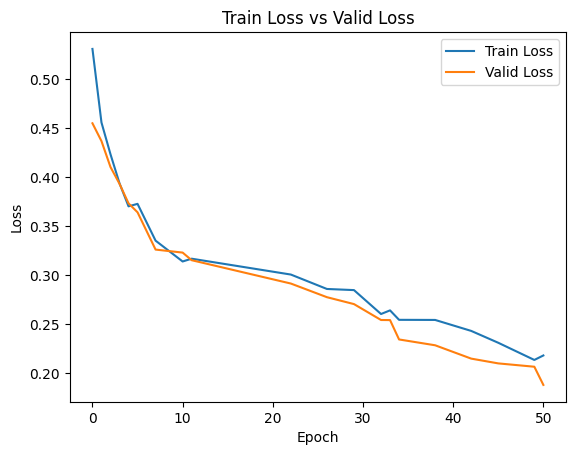

In [3]:
import json 

losses = []

train_hist_dir = 'pytorch-mask-r-cnn-instance-segmentation/2024-05-10_18-18-56_new_ds/training_metadata.json'
with open(train_hist_dir, 'r') as file:
    data_epochs = json.load(file)
    
    for data_epoch in data_epochs:
        train_loss = data_epoch['train_loss']
        valid_loss = data_epoch['valid_loss']
        epoch = data_epoch['epoch']
        losses.append((epoch, train_loss, valid_loss))
       
# Extract the data for plotting
epochs = [epoch for epoch, _, _ in losses]
train_losses = [train_loss for _, train_loss, _ in losses]
valid_losses = [valid_loss for _, _, valid_loss in losses]

# Plot the train_loss and valid_loss
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Valid Loss')

# Add labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Valid Loss')

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()


In [37]:
# Load weights from a .pth file
weights_path = "pytorch-mask-r-cnn-instance-segmentation/2024-05-10_18-18-56_new_ds/maskrcnn_resnet50_fpn_v2.pth"
model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

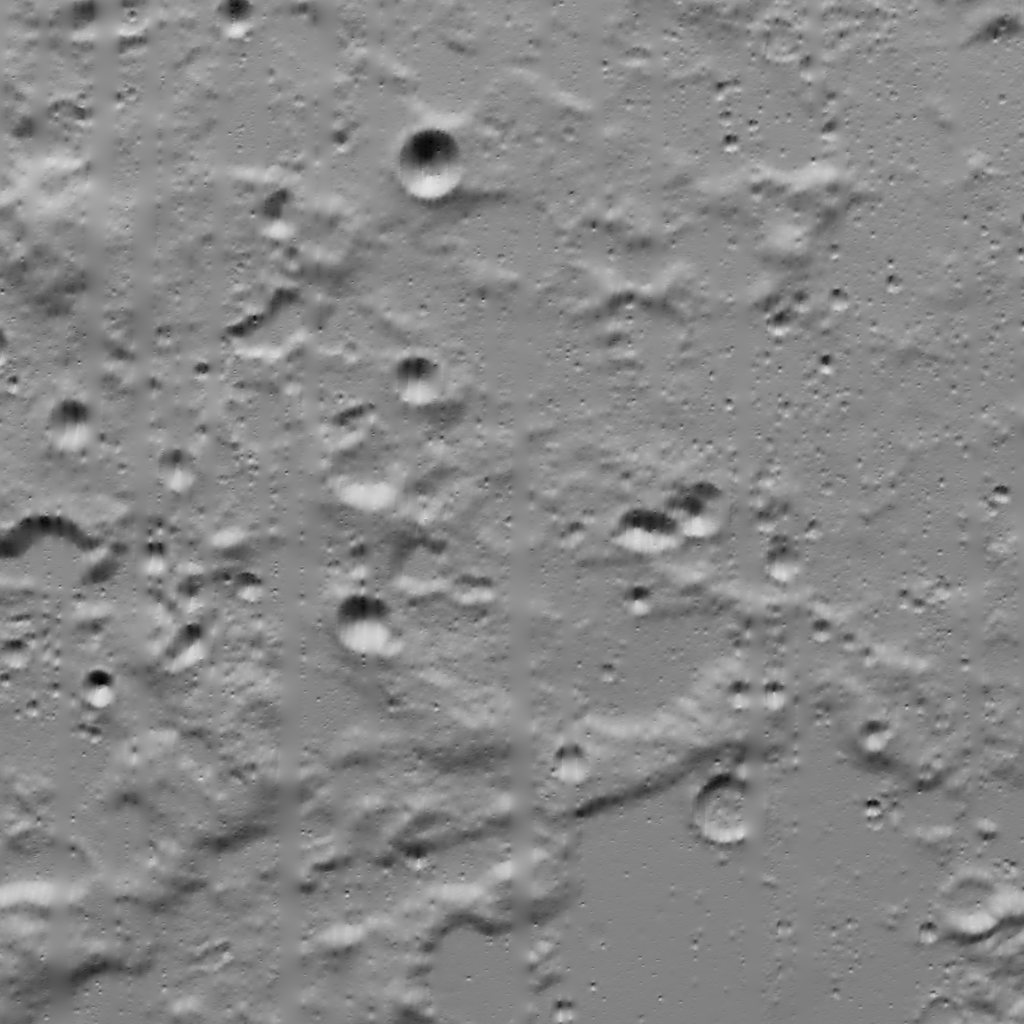

Source Image Size:,"(1024, 1024)"
Input Dims:,"(1024, 1024)"
Min Image Scale:,1.000000
Input Image Size:,"(1024, 1024)"
Test_file:,data\sofia_data_v2\ground_truth_images\17.png


In [38]:
# Choose a random item from the validation set
file_id = random.choice(val_keys)

# Retrieve the image file path associated with the file ID map(float, data[
test_file = img_dict[file_id]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Resize the test image
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size,
    "Test_file:": test_file
}).to_frame().style.hide(axis='columns')

In [39]:
test_annot_filename = test_file.split('/')[-1].split('.')[0] + '.txt'
# annot_filename
annot_file_path = os.path.join(images_ellipses_dir, test_annot_filename)
annot_file_path

'data\\sofia_data_v2\\ground_truth_projected_ellipses\\17.txt'

In [40]:
def get_mask(x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation) -> np.ndarray:
    mask = np.zeros((1024, 1024), dtype=np.uint8)
    
    cv2.ellipse(mask, (int(x_centre), int(y_centre)),
                (int(semi_major_axis), int(semi_minor_axis)),
                angle=rotation, startAngle=0, endAngle=360,
                color=1, thickness=-1)
    
    return mask

def get_box(mask: np.ndarray):
    pos = np.nonzero(mask)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    return [xmin, ymin, xmax, ymax]

def get_target(annot_file_path):       
        
        target = {
            "boxes": [],
            "masks": [],
            "labels": [],
        }
        with open(annot_file_path, "r") as f:
            lines = f.readlines()[1:]
            for line in lines:
                label = 'crater' 
                data = line.strip().split(',')
                # Extract ellipse parameters
                x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation = map(float, data[:-1])
                rotation = np.degrees(rotation)
                mask = get_mask(x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation)
                
                box = get_box(mask)
                target["masks"].append(mask)    
                target["boxes"].append(box)
                target["labels"].append(label)


        
        # Convert the class labels to indices
        labels_tensor = target['labels']

        # Generate bounding box annotations from segmentation masks
        masks_tensor = torch.stack([torch.Tensor(mask).bool() for mask in target['masks']])

        # Generate bounding box annotations from segmentation masks
        bboxes_tensor = torch.Tensor(target['boxes']).to(dtype=torch.float32)

        
                
        return {'masks': masks_tensor,'boxes': bboxes_tensor, 'labels': labels_tensor}

In [41]:
targets = get_target(annot_file_path)

target_masks = targets['masks']

# Get the target labels and bounding boxes
target_labels = targets['labels']
target_bboxes = targets['boxes']

In [42]:
# Set the model to evaluation mode
model.eval()

# Ensure the model and input data are on the same device
model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)

In [43]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold

# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']

# Scale and stack the predicted segmentation masks
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])   

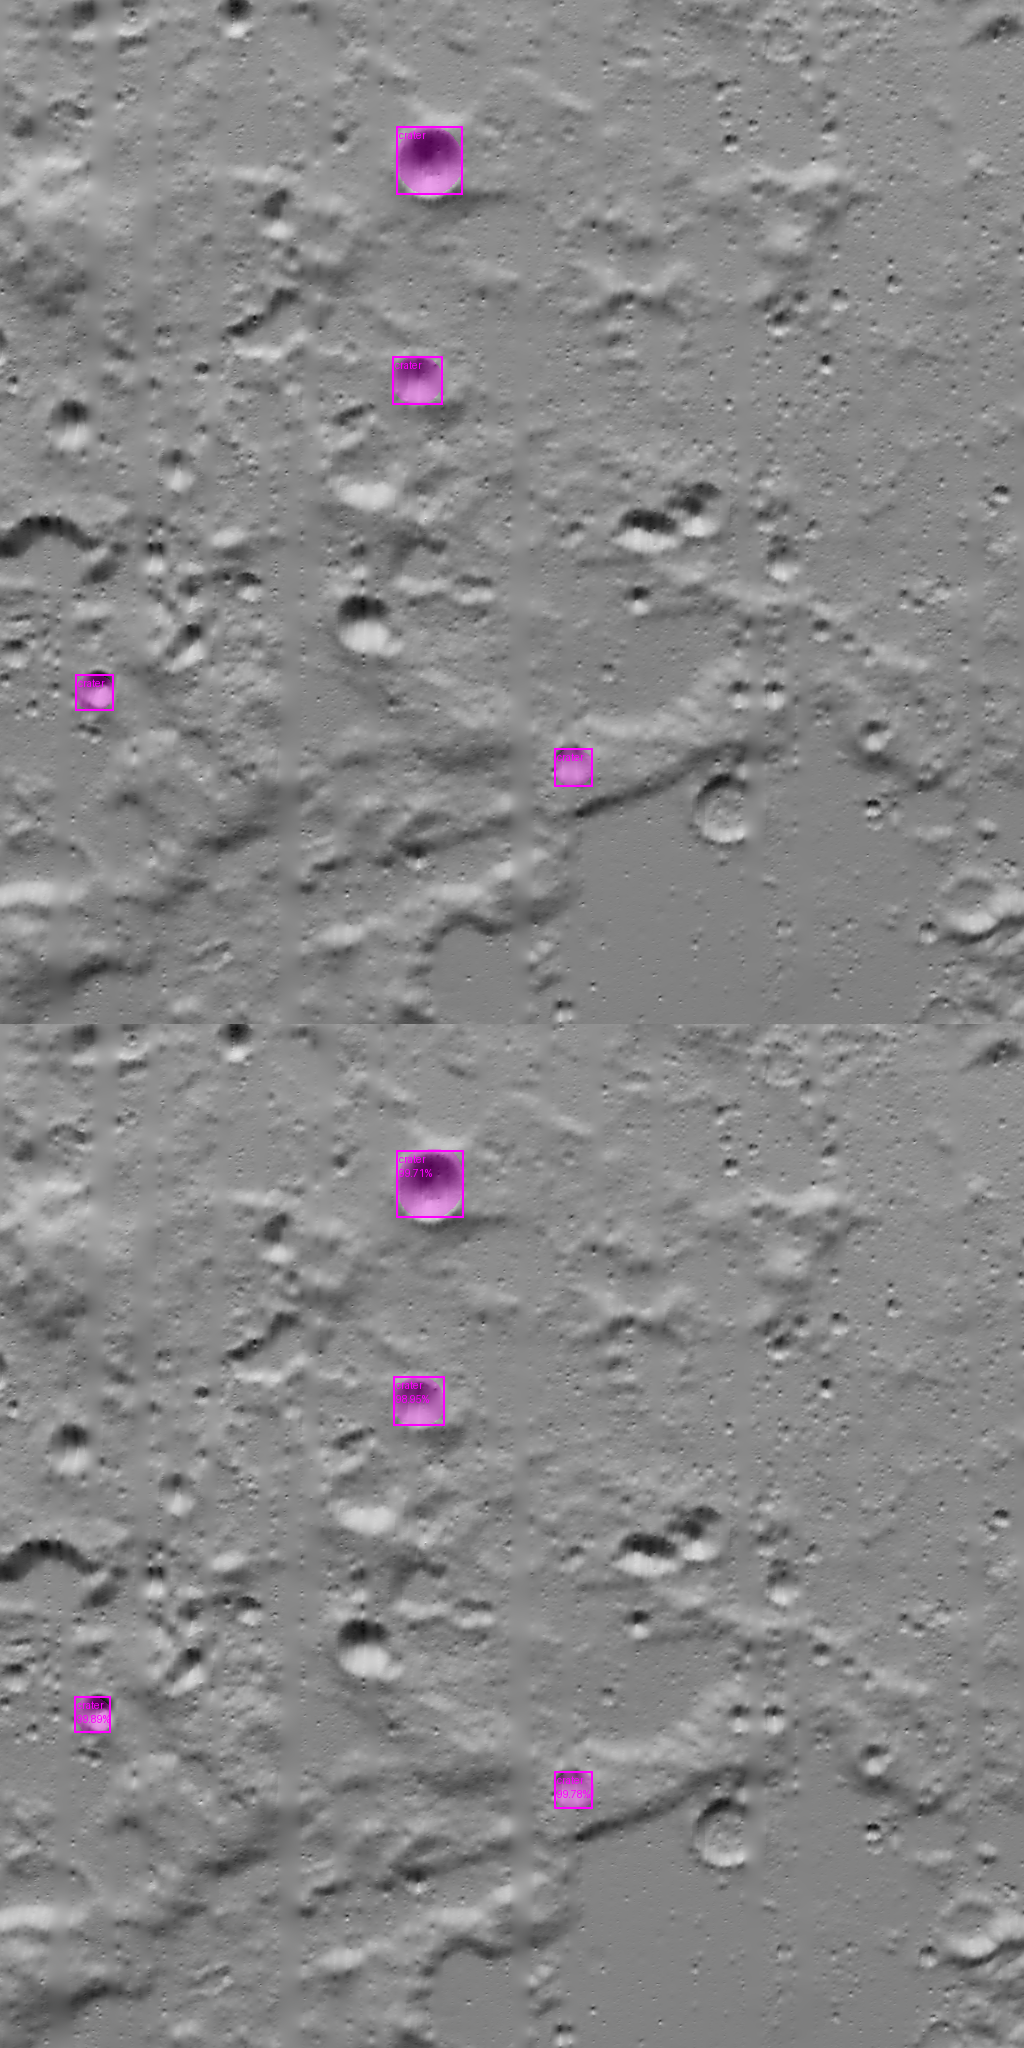

Target BBoxes:,"['crater:[554. 748. 592. 786.]', 'crater:[ 75. 674. 113. 710.]', 'crater:[392. 356. 442. 404.]', 'crater:[396. 126. 462. 194.]']"
Predicted BBoxes:,"['crater:[ 74.553 672.104 110.699 708.942]', 'crater:[554.598 747.018 592.78 784.365]', 'crater:[396.48 126.156 463.534 193.086]', 'crater:[393.594 352.892 444.043 401.918]']"
Confidence Scores:,"['crater: 99.89%', 'crater: 99.78%', 'crater: 99.71%', 'crater: 98.95%']"


In [44]:
# Get the annotation colors for the targets and predictions
target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

# Convert the test images to a tensor
img_tensor = transforms.PILToTensor()(test_img)

# Annotate the test image with the target segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
# Annotate the test image with the target bounding boxes
annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
# Display the annotated test image
annotated_test_img = tensor_to_pil(annotated_tensor)

# Annotate the test image with the predicted segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
# Annotate the test image with the predicted labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=pred_bboxes, 
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

# Display the annotated test image with the predicted bounding boxes
display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')

In [46]:
test_images = {} #{'id': [image_with_ellipses: np.array, [gt_bboxs:list[list], pred_bboxes:list[list], [gt_ellipses:list[list], pred_ellipses:list[list]]]}

boxes_dir = 'data/sofia_data_v2/ground_truth_bounding_boxes'


for idx in tqdm(val_keys):
    bounding_boxes = []
    ellipses_ = []
    
    test_file = img_dict[idx]
    test_img = Image.open(test_file).convert('RGB')
    
    input_img = resize_img(test_img, target_sz=train_sz, divisor=1)
    input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

    # Make a prediction with the model
    with torch.no_grad():
        model_output = model(input_tensor)
    
    # Set the confidence threshold
    threshold = 0.5

    # Move model output to the CPU
    model_output = move_data_to_device(model_output, 'cpu')

    # Filter the output based on the confidence threshold
    scores_mask = model_output[0]['scores'] > threshold

    # Scale the predicted bounding boxes
    pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

    # Scale and stack the predicted segmentation masks
    pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
    pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])   
    
    
    input_img_np = np.array(resize_img(input_img, target_sz=1024, divisor=1))
    
    #draw GT
    test_annot_filename = test_file.split('/')[-1].split('.')[0] + '.txt'
    annot_ellipses_path = os.path.join(images_ellipses_dir, test_annot_filename)
    with open(annot_ellipses_path, 'r') as f:
        lines = f.readlines()[1:]
        gt_ellipses = []
        for line in lines:
            data = line.strip().split(',')
            # Extract box parameters
            x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation = map(float, data[:-1])
            gt_ellipses.append([x_centre, y_centre, semi_major_axis, semi_minor_axis, np.degrees(rotation)]) 
            
            cv2.ellipse(input_img_np, (int(x_centre), int(y_centre)), (int(semi_major_axis), int(semi_minor_axis)), angle=np.degrees(rotation), startAngle=0, endAngle=360, color=(0, 255, 0), thickness=2) 
        ellipses_.append(gt_ellipses)
        f.close()
        
    annot_bboxes_path = os.path.join(boxes_dir, test_annot_filename)
    with open(annot_bboxes_path, 'r') as f:
        lines = f.readlines()[1:]
        bboxes = []
        for line in lines:
            data = line.strip().split(',')
            # Extract box parameters
            x1, y1, x2, y2 = map(int, data)
            bboxes.append([x1, y1, x2, y2])
            
        bounding_boxes.append(bboxes)
        f.close()
    
    # draw Pred
    pred_ellipses = []
    for mask in pred_masks:
        
        # Find contours of the mask
        contours, _ = cv2.findContours(mask.numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours)>1:
                contours = [max(contours, key=cv2.contourArea)]
        # Fit ellipse to the contour
        if len(contours[0]) >=5:
            ellipse_params = cv2.fitEllipse(contours[0]) #((x,y), (majorAxis, minorAxis), angle(degree))
        
            param = []
            param.append(ellipse_params[0][0])
            param.append(ellipse_params[0][1])
            param.append(ellipse_params[1][0])
            param.append(ellipse_params[1][1])
            param.append(ellipse_params[2])
            pred_ellipses.append(param)
            
            ellipse_area = np.pi * (ellipse_params[1][0] / 2) * (ellipse_params[1][1] / 2)
            ellipse_peri = 2 * np.pi * np.sqrt(ellipse_area/np.pi)
            contour_peri = cv2.arcLength(contours[0], closed=True)
            
            T = ellipse_peri/contour_peri if ellipse_peri <= contour_peri else contour_peri/ellipse_peri
            if T >= 0.8: #ellipse_index_threshhold
            # Plot the contour
                cv2.ellipse(input_img_np, ellipse_params, color=(255, 0, 0), thickness=2)
    
    ellipses_.append(pred_ellipses)
                   
    pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])   
    pred_bboxes =  pred_bboxes.round(decimals=3).numpy().tolist()
    bounding_boxes.append(pred_bboxes)
    
    test_images[idx] = [input_img_np, bounding_boxes, ellipses_]

  0%|          | 0/193 [00:00<?, ?it/s]

In [47]:
def calculate_iou(box1, box2):
        # Calculate the intersection area
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

        # Calculate the union area
        box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
        box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
        union_area = box1_area + box2_area - intersection_area

        # Calculate the IoU
        iou = intersection_area / union_area
        return iou

In [48]:
TP = 0
FP = 0
FN = 0

threshold = 0.5
for id, content in test_images.items():
    bounding_boxes = content[1]
    ground_truth_boxes = bounding_boxes[0]
    predicted_boxes = bounding_boxes[1]
    
    # Initialize arrays to track whether a ground truth or prediction has been matched
    gt_matched = [False] * len(ground_truth_boxes)
    pred_matched = [False] * len(predicted_boxes)
    
    # Iterate over each predicted bounding box
    for pred_idx, pred_box in enumerate(predicted_boxes):
        max_iou = 0
        max_iou_idx = -1
        
        # Iterate over each ground truth bounding box to find the one with maximum IOU
        for gt_idx, gt_box in enumerate(ground_truth_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                max_iou_idx = gt_idx
        
        # If the maximum IOU is above a threshold, consider it a true positive
        if max_iou >= threshold:
            TP += 1
            gt_matched[max_iou_idx] = True
            pred_matched[pred_idx] = True
        else:
            FP += 1
    
    # Any ground truth boxes not matched to predictions are false negatives
    FN += sum(not matched for matched in gt_matched)
    
# Calculate false negatives for predictions not matched to any ground truth
FN += sum(not matched for matched in pred_matched)

# Calculate accuracy, precision, and recall
accuracy = (TP) / (TP + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.8747433264887063
Precision: 0.8810754912099276
Recall: 0.9918509895227008
F1 Score: 0.9331872946330777


In [ ]:
for id, content in test_images.items():
    img = content[0]
    img = cv2.rotate(img, cv2.ROTATE_180)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
